#### ***Import Libraries***

### Block 1: Library Imports and Device Configuration

This first block loads the main libraries used throughout the notebook:

- **NumPy & Pandas** for data manipulation.
- **Matplotlib** for basic visualizations.
- **PyTorch** to define, train, and evaluate the neural recommendation model.
- **Scikit-learn** for dataset splitting and evaluation metrics.

At the end, the code also checks whether a GPU is available. If it is, the model and tensors will be moved to the GPU for faster training.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [25]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Block 2: Loading and Preprocessing the Ratings Data

In this block, the `ratings.dat` file is loaded and preprocessed as follows:

- Users and movies with fewer than 5 ratings are removed to reduce sparsity.
- The `timestamp` field is converted to datetime format, and new temporal features are extracted: year, month, and day of the week.
- Ratings are normalized to the \[0, 1\] range by dividing them by 5. This helps stabilize the training process of the neural network.

In [26]:
# Load ratings dataset
ratings = pd.read_csv("../data/ml-1m/ratings.dat", sep="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "Timestamp"])

print("Initial shape:", ratings.shape)

# Filter users and movies with at least 5 ratings
ratings = ratings[ratings['UserID'].map(ratings['UserID'].value_counts()) >= 5]
ratings = ratings[ratings['MovieID'].map(ratings['MovieID'].value_counts()) >= 5]

print("Users after filtering:", ratings['UserID'].nunique())
print("Movies after filtering:", ratings['MovieID'].nunique())

# Convert timestamp and extract date-related features
ratings['Datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings['Year'] = ratings['Datetime'].dt.year
ratings['Month'] = ratings['Datetime'].dt.month
ratings['DayOfWeek'] = ratings['Datetime'].dt.dayofweek

# Normalize ratings to [0, 1]
ratings['Rating_Norm'] = ratings['Rating'] / 5.0

# Show sample after preprocessing
ratings.head()

Initial shape: (1000209, 4)
Users after filtering: 6040
Movies after filtering: 3416


,UserID,MovieID,Rating,Timestamp,Datetime,Year,Month,DayOfWeek,Rating_Norm
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,12,6,1.0
1,1,661,3,978302109,2000-12-31 22:35:09,2000,12,6,0.6
2,1,914,3,978301968,2000-12-31 22:32:48,2000,12,6,0.6
3,1,3408,4,978300275,2000-12-31 22:04:35,2000,12,6,0.8
4,1,2355,5,978824291,2001-01-06 23:38:11,2001,1,5,1.0


### Block 2.1: Loading and Preprocessing Additional Data

In this block, I load and preprocess the `users.dat` and `movies.dat` files:

- **users.dat** contains basic information about users: UserID, Gender, Age, Occupation, and Zip-code.
  - `Gender` is encoded as 0 for "F" (female) and 1 for "M" (male).
  - `Age` and `Occupation` are kept as numerical features. These can be treated as categories later if embeddings are used.

- **movies.dat** contains details about each movie: MovieID, Title, and Genres.
  - The `Genres` column includes multiple genres per movie, separated by the `|` symbol.
  - Each genre is extracted into a list, and a mapping is created from genre names to integer indices. These can be used for embeddings or multi-hot encodings later.

In [ ]:
# Load users.dat
users = pd.read_csv("../data/ml-1m/users.dat", sep="::", engine="python", header=None,
                    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

# Process user features
users["Gender"] = users["Gender"].map({"F": 0, "M": 1})  # Encode gender
users["Age"] = users["Age"].astype(int)
users["Occupation"] = users["Occupation"].astype(int)

# Load movies.dat
movies = pd.read_csv("../data/ml-1m/movies.dat", sep="::", engine="python", header=None,
                     names=["MovieID", "Title", "Genres"], encoding="latin-1")

# Process genres
movies["Genres_list"] = movies["Genres"].str.split("|")

# Create genre-to-index mapping
all_genres = sorted(set(genre for sublist in movies["Genres_list"] for genre in sublist))
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

# Convert genres to indices
movies["Genres_indices"] = movies["Genres_list"].apply(lambda genres: [genre_to_index[g] for g in genres])

### Block 3: Merging User, Movie, and Rating Data

In this block, I merge the following sources into a single dataset:

- **ratings.dat:** Contains user-movie interactions and timestamps.
- **users.dat:** Adds user information such as gender, age, and occupation.
- **movies.dat:** Adds movie details, including the title and genre list (as indices).

The result is a DataFrame where each rating entry is enriched with both user and movie features, which will be used later as inputs for the model.

In [28]:
# Merge ratings with user information
ratings_merged = ratings.merge(users, on="UserID", how="left")

# Merge with movie information (keeping only relevant movie columns)
ratings_merged = ratings_merged.merge(
    movies[["MovieID", "Title", "Genres_list", "Genres_indices"]],
    on="MovieID", how="left"
)

# Display shape and a preview
print("Merged DataFrame shape:", ratings_merged.shape)
ratings_merged.head()

Merged DataFrame shape: (999611, 16)


,UserID,MovieID,Rating,Timestamp,Datetime,Year,Month,DayOfWeek,Rating_Norm,Gender,Age,Occupation,Zip-code,Title,Genres_list,Genres_indices
0,1,1193,5,978300760,2000-12-31 22:12:40,2000,12,6,1.0,0,1,10,48067,One Flew Over the Cuckoo's Nest (1975),[Drama],[7]
1,1,661,3,978302109,2000-12-31 22:35:09,2000,12,6,0.6,0,1,10,48067,James and the Giant Peach (1996),"[Animation, Children's, Musical]","[2, 3, 11]"
2,1,914,3,978301968,2000-12-31 22:32:48,2000,12,6,0.6,0,1,10,48067,My Fair Lady (1964),"[Musical, Romance]","[11, 13]"
3,1,3408,4,978300275,2000-12-31 22:04:35,2000,12,6,0.8,0,1,10,48067,Erin Brockovich (2000),[Drama],[7]
4,1,2355,5,978824291,2001-01-06 23:38:11,2001,1,5,1.0,0,1,10,48067,"Bug's Life, A (1998)","[Animation, Children's, Comedy]","[2, 3, 4]"


### Block 4: Custom Dataset and DataLoaders with Extra Features

In this block, I prepare the data for model training by building a custom `Dataset` class that includes both standard and enriched features.

Key steps:

- User and movie IDs are mapped to consecutive integer indices using `pd.factorize`, to make them compatible with embedding layers.
- Movie genres are encoded as multi-hot vectors based on the previously generated `genre_to_index` mapping.
- For each training sample, the dataset returns:
  - `user`: index of the user,
  - `movie`: index of the movie,
  - `rating`: normalized score in the \[0, 1\] range,
  - `user_features`: a float vector with Gender, Age, and Occupation,
  - `movie_features`: a multi-hot vector indicating which genres are present.

Finally, the dataset is split into training, validation, and test sets **per user**, preserving the temporal order of interactions. Each split is wrapped in a PyTorch `DataLoader` for efficient batching during training and evaluation.

In [29]:
### 1. Map user and movie IDs to consecutive indices
if 'userIndex' not in ratings_merged.columns:
    ratings_merged['userIndex'] = pd.factorize(ratings_merged['UserID'])[0]
if 'movieIndex' not in ratings_merged.columns:
    ratings_merged['movieIndex'] = pd.factorize(ratings_merged['MovieID'])[0]

print("UserIndex range:", ratings_merged['userIndex'].min(), "-", ratings_merged['userIndex'].max())
print("MovieIndex range:", ratings_merged['movieIndex'].min(), "-", ratings_merged['movieIndex'].max())

UserIndex range: 0 - 6039
MovieIndex range: 0 - 3415


In [30]:
### 2. Convert genres into multi-hot vectors
n_genres = len(genre_to_index)

def create_multi_hot(indices):
    vec = np.zeros(n_genres, dtype=int)
    for idx in indices:
        vec[idx] = 1
    return vec.tolist()

ratings_merged['Genres_multi_hot'] = ratings_merged['Genres_indices'].apply(create_multi_hot)

print("\nExample of multi-hot encoding:")
print(ratings_merged[['MovieID', 'Genres_indices', 'Genres_multi_hot']].head())


Example of multi-hot encoding:
   MovieID Genres_indices                                   Genres_multi_hot
0     1193            [7]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1      661     [2, 3, 11]  [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2      914       [11, 13]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
3     3408            [7]  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
4     2355      [2, 3, 4]  [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [31]:
### 3. Define the custom dataset class
class MovieLensEnhancedDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['userIndex'].values, dtype=torch.long)
        self.movies = torch.tensor(data['movieIndex'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['Rating_Norm'].values, dtype=torch.float32)
        
        self.user_features = torch.tensor(data[['Gender', 'Age', 'Occupation']].values, dtype=torch.float32)
        self.movie_features = data['Genres_multi_hot'].values  # Lists → tensors in __getitem__
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        movie_feat = torch.tensor(self.movie_features[idx], dtype=torch.float32)
        return {
            "user": self.users[idx],
            "movie": self.movies[idx],
            "rating": self.ratings[idx],
            "user_features": self.user_features[idx],
            "movie_features": movie_feat
        }

In [32]:
### 4. Split data into train / val / test by user
train_list, val_list, test_list = [], [], []

for user_id, group in ratings_merged.groupby("UserID"):
    group = group.sort_values("Timestamp")
    train, temp = train_test_split(group, test_size=0.30, random_state=42)
    val, test = train_test_split(temp, test_size=0.50, random_state=42)
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (697017, 19)
Val: (149779, 19)
Test: (152815, 19)


In [33]:
### 5. Build datasets and DataLoaders
train_dataset_enh = MovieLensEnhancedDataset(train_df)
val_dataset_enh = MovieLensEnhancedDataset(val_df)
test_dataset_enh = MovieLensEnhancedDataset(test_df)

batch_size = 512

train_loader_enh = DataLoader(train_dataset_enh, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_enh = DataLoader(val_dataset_enh, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_enh = DataLoader(test_dataset_enh, batch_size=batch_size, shuffle=False, num_workers=0)

print("Enhanced datasets:")
print("Train:", len(train_dataset_enh))
print("Val:", len(val_dataset_enh))
print("Test:", len(test_dataset_enh))

Enhanced datasets:
Train: 697017
Val: 149779
Test: 152815


### Block 5: Definition of the Enhanced Recommendation Model

In this block, I define the final model architecture. It not only uses user and movie IDs, but also integrates:

- **User features:** Gender, Age, and Occupation (as a numerical vector).
- **Movie features:** Multi-hot encoded vector representing the movie's genres.

The architecture follows these main steps:

1. Embed the user and movie IDs using separate embedding layers.
2. Process the additional user and movie features through dedicated linear layers.
3. Concatenate all learned representations into a single feature vector.
4. Pass the concatenated vector through a Multi-Layer Perceptron (MLP) to predict the rating.

This hybrid architecture allows the model to learn from both IDs and rich metadata, improving recommendation accuracy.

In [34]:
class NeuMFEnhanced(nn.Module):
    def __init__(self, num_users, num_movies, num_genres,
                 user_embedding_dim=32, movie_embedding_dim=32,
                 user_feature_dim=3, movie_feature_output_dim=16,
                 mlp_layers=[128, 64], dropout=0.3):
        super(NeuMFEnhanced, self).__init__()

        ### Embedding layers
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, movie_embedding_dim)

        ### Feature processing layers
        # User: [Gender, Age, Occupation] → user_embedding_dim
        self.user_feat_fc = nn.Linear(user_feature_dim, user_embedding_dim)

        # Movie: multi-hot vector of genres → movie_feature_output_dim
        self.movie_feat_fc = nn.Linear(num_genres, movie_feature_output_dim)

        ### Fusion MLP layers
        fusion_input_dim = (2 * user_embedding_dim) + movie_embedding_dim + movie_feature_output_dim

        self.fusion_fc1 = nn.Linear(fusion_input_dim, mlp_layers[0])
        self.bn1 = nn.BatchNorm1d(mlp_layers[0])
        
        self.fusion_fc2 = nn.Linear(mlp_layers[0], mlp_layers[1])
        self.bn2 = nn.BatchNorm1d(mlp_layers[1])
        
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(mlp_layers[1], 1)

    def forward(self, user_id, movie_id, user_features, movie_features):
        # Embeddings
        user_emb = self.user_embedding(user_id)
        movie_emb = self.movie_embedding(movie_id)

        # Feature transformations
        user_extra = self.user_feat_fc(user_features)
        movie_extra = self.movie_feat_fc(movie_features)

        # Combine user and movie representations
        user_combined = torch.cat([user_emb, user_extra], dim=1)
        movie_combined = torch.cat([movie_emb, movie_extra], dim=1)
        fusion_input = torch.cat([user_combined, movie_combined], dim=1)

        # MLP forward pass
        x = self.fusion_fc1(fusion_input)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.fusion_fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        return self.output(x).squeeze()

In [35]:
# Model initialization
num_users = train_df['userIndex'].max() + 1
num_movies = train_df['movieIndex'].max() + 1
num_genres = len(genre_to_index)

model_enhanced = NeuMFEnhanced(
    num_users=num_users,
    num_movies=num_movies,
    num_genres=num_genres,
    user_embedding_dim=32,
    movie_embedding_dim=32,
    user_feature_dim=3,
    movie_feature_output_dim=16,
    mlp_layers=[128, 64],
    dropout=0.3
).to(device)

print(model_enhanced)

NeuMFEnhanced(
  (user_embedding): Embedding(6040, 32)
  (movie_embedding): Embedding(3416, 32)
  (user_feat_fc): Linear(in_features=3, out_features=32, bias=True)
  (movie_feat_fc): Linear(in_features=18, out_features=16, bias=True)
  (fusion_fc1): Linear(in_features=112, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fusion_fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


### Block 6: Training the Enhanced Model

In this block, I train the enhanced model (`NeuMFEnhanced`) using the enriched dataset (`train_loader_enh`, `val_loader_enh`, and `test_loader_enh`).

The training setup includes:

- **Loss function:** Mean Squared Error (MSE), since we are predicting continuous ratings.
- **Optimizer:** Adam, which adapts the learning rate during training.
- **Learning rate scheduler:** Reduces the learning rate if the validation loss does not improve for a few epochs.
- **Early stopping:** Stops training early if the validation loss stops improving, helping to prevent overfitting.

During training, the model is evaluated on the validation set after each epoch to monitor its generalization performance.

In [36]:
# Training configuration
num_epochs_enh = 30
criterion_enh = nn.MSELoss()
optimizer_enh = optim.Adam(model_enhanced.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_enh = optim.lr_scheduler.ReduceLROnPlateau(optimizer_enh, mode='min', factor=0.5, patience=2)

# Early stopping setup
best_val_loss_enh = float('inf')
early_stopping_counter_enh = 0
patience_enh = 5

# Tracking loss history
train_losses_enh = []
val_losses_enh = []

# Training loop
for epoch in range(num_epochs_enh):
    model_enhanced.train()
    running_train_loss = 0.0

    for batch in train_loader_enh:
        users = batch["user"].to(device)
        movies = batch["movie"].to(device)
        ratings_batch = batch["rating"].to(device)
        user_features = batch["user_features"].to(device)
        movie_features = batch["movie_features"].to(device)

        # Forward + loss
        preds = model_enhanced(users, movies, user_features, movie_features)
        loss = criterion_enh(preds, ratings_batch)

        # Backward + optimize
        optimizer_enh.zero_grad()
        loss.backward()
        optimizer_enh.step()

        running_train_loss += loss.item() * ratings_batch.size(0)

    avg_train_loss = running_train_loss / len(train_dataset_enh)
    train_losses_enh.append(avg_train_loss)

    # Validation loop
    model_enhanced.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader_enh:
            users = batch["user"].to(device)
            movies = batch["movie"].to(device)
            ratings_batch = batch["rating"].to(device)
            user_features = batch["user_features"].to(device)
            movie_features = batch["movie_features"].to(device)

            preds = model_enhanced(users, movies, user_features, movie_features)
            loss = criterion_enh(preds, ratings_batch)
            running_val_loss += loss.item() * ratings_batch.size(0)

    avg_val_loss = running_val_loss / len(val_dataset_enh)
    val_losses_enh.append(avg_val_loss)
    scheduler_enh.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs_enh} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss_enh:
        best_val_loss_enh = avg_val_loss
        early_stopping_counter_enh = 0
        #torch.save(model_enhanced.state_dict(), "best_model_enhanced.pth")
    else:
        early_stopping_counter_enh += 1
        if early_stopping_counter_enh >= patience_enh:
            print("Early stopping triggered.")
            break

print("Training completed.")

Epoch 1/30 - Train Loss: 0.0719 - Val Loss: 0.0465
Epoch 2/30 - Train Loss: 0.0411 - Val Loss: 0.0366
Epoch 3/30 - Train Loss: 0.0362 - Val Loss: 0.0373
Epoch 4/30 - Train Loss: 0.0355 - Val Loss: 0.0357
Epoch 5/30 - Train Loss: 0.0352 - Val Loss: 0.0339
Epoch 6/30 - Train Loss: 0.0348 - Val Loss: 0.0334
Epoch 7/30 - Train Loss: 0.0345 - Val Loss: 0.0337
Epoch 8/30 - Train Loss: 0.0341 - Val Loss: 0.0330
Epoch 9/30 - Train Loss: 0.0338 - Val Loss: 0.0330
Epoch 10/30 - Train Loss: 0.0330 - Val Loss: 0.0321
Epoch 11/30 - Train Loss: 0.0322 - Val Loss: 0.0313
Epoch 12/30 - Train Loss: 0.0316 - Val Loss: 0.0310
Epoch 13/30 - Train Loss: 0.0311 - Val Loss: 0.0307
Epoch 14/30 - Train Loss: 0.0308 - Val Loss: 0.0307
Epoch 15/30 - Train Loss: 0.0305 - Val Loss: 0.0304
Epoch 16/30 - Train Loss: 0.0302 - Val Loss: 0.0307
Epoch 17/30 - Train Loss: 0.0300 - Val Loss: 0.0303
Epoch 18/30 - Train Loss: 0.0298 - Val Loss: 0.0305
Epoch 19/30 - Train Loss: 0.0296 - Val Loss: 0.0301
Epoch 20/30 - Train L

# Visualización: Evolución del Loss

Este gráfico muestra cómo evolucionaron las pérdidas (loss) en el conjunto de entrenamiento y validación a lo largo de las épocas. Esto nos ayuda a identificar si el modelo converge adecuadamente y si existe sobreajuste.

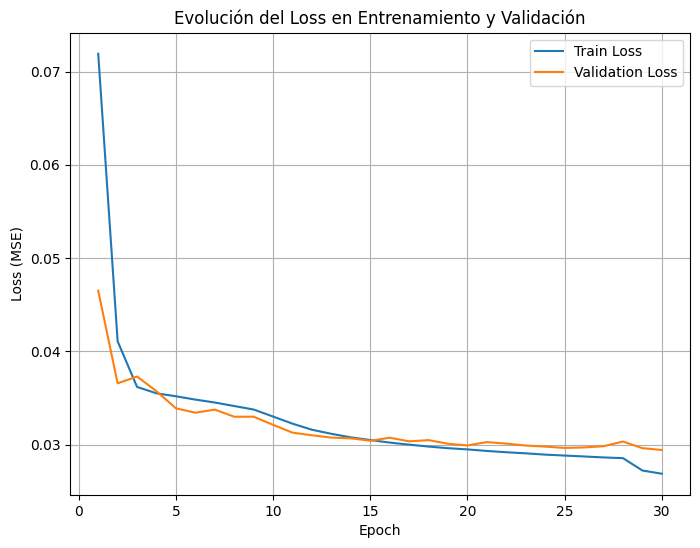

In [37]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses_enh)+1), train_losses_enh, label='Train Loss')
plt.plot(range(1, len(val_losses_enh)+1), val_losses_enh, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Evolución del Loss en Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()

### 📊 Block 7: Evaluation and Visualization of the Model

In this block, I evaluate the final performance of the improved model and visualize the results.

Steps included:

- **Load the best model weights** saved during training (`best_model_enhanced.pth`).
- **Evaluate** the model on the test set (`test_loader_enh`) using standard regression metrics:
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Error (MAE)
  - Coefficient of determination (R²)
- **Visualize** the model's performance with:
  - A scatter plot comparing predicted vs. actual ratings.
  - A histogram showing the distribution of prediction errors.
  - A residual plot to inspect how errors vary across the prediction range.

These visualizations help diagnose potential biases or inconsistencies in the predictions.

In [38]:
### 1. Load the best saved model
#model_enhanced.load_state_dict(torch.load("best_model_enhanced.pth", map_location=device))
model_enhanced.eval()

### 2. Generate predictions on the test set
y_true_enh = []
y_pred_enh = []

with torch.no_grad():
    for batch in test_loader_enh:
        users = batch["user"].to(device)
        movies = batch["movie"].to(device)
        ratings_batch = batch["rating"].to(device)
        user_features = batch["user_features"].to(device)
        movie_features = batch["movie_features"].to(device)

        preds = model_enhanced(users, movies, user_features, movie_features)
        y_true_enh.extend(ratings_batch.cpu().numpy())
        y_pred_enh.extend(preds.cpu().numpy())

y_true_enh = np.array(y_true_enh)
y_pred_enh = np.array(y_pred_enh)

### 3. Compute regression metrics
rmse_enh = np.sqrt(mean_squared_error(y_true_enh, y_pred_enh))
mae_enh = mean_absolute_error(y_true_enh, y_pred_enh)
r2_enh = r2_score(y_true_enh, y_pred_enh)

In [39]:
# Set evaluation cutoff
k = 10

# Store predictions and ground truth ratings grouped by user
user_preds_enh = defaultdict(list)
user_truth_enh = defaultdict(list)

model_enhanced.eval()
with torch.no_grad():
    for batch in test_loader_enh:
        users = batch["user"].to(device)
        movies = batch["movie"].to(device)
        ratings_batch = batch["rating"].to(device)
        user_features = batch["user_features"].to(device)
        movie_features = batch["movie_features"].to(device)

        preds = model_enhanced(users, movies, user_features, movie_features)

        # Group predictions and actual ratings by user
        for u, pred, true in zip(users.cpu().numpy(), preds.cpu().numpy(), ratings_batch.cpu().numpy()):
            user_preds_enh[u].append(pred)
            user_truth_enh[u].append(true)

# NDCG@K function
def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

# Evaluate ranking quality
precisions_enh = []
ndcgs_enh = []

for u in user_preds_enh:
    preds_u = np.array(user_preds_enh[u])
    truths_u = np.array(user_truth_enh[u])

    # Binary relevance: 1 if rating ≥ 0.8 (i.e., 4/5), else 0
    relevant = (truths_u >= 0.8).astype(int)

    # Top-k predicted items
    top_k_indices = np.argsort(-preds_u)[:k]

    # Precision@k
    precision_u = np.sum(relevant[top_k_indices]) / k
    precisions_enh.append(precision_u)

    # NDCG@k
    ndcg_u = ndcg_at_k(relevant[top_k_indices], k)
    ndcgs_enh.append(ndcg_u)

# Final average metrics
precision_at_k_enh = np.mean(precisions_enh)
ndcg_at_k_enh = np.mean(ndcgs_enh)

### Additional Ranking Metrics

In addition to standard regression metrics and NDCG@10, I also compute:

- **Recall@10:** Measures how many of the relevant items were correctly recommended in the top 10.
- **F1@10:** Harmonic mean of Precision@10 and Recall@10, offering a balanced evaluation of accuracy and coverage.

These metrics help evaluate how useful the recommendations are from the user's perspective.

In [40]:
recalls_enh = []

for u in user_preds_enh:
    preds_u = np.array(user_preds_enh[u])
    truths_u = np.array(user_truth_enh[u])
    
    relevant = (truths_u >= 0.8).astype(int)
    top_k_indices = np.argsort(-preds_u)[:k]
    
    num_relevant = np.sum(relevant)
    recall_u = np.sum(relevant[top_k_indices]) / num_relevant if num_relevant > 0 else 0.0
    recalls_enh.append(recall_u)

recall_at_k_enh = np.mean(recalls_enh)

In [41]:
f1_at_k_enh = 2 * (precision_at_k_enh * recall_at_k_enh) / (precision_at_k_enh + recall_at_k_enh + 1e-8)

### Dataframe with all the metrics

In [42]:
metrics_dict = {
    "RMSE": [rmse_enh],
    "MAE": [mae_enh],
    "R²": [r2_enh],
    "Precision@10": [precision_at_k_enh],
    "Recall@10": [recall_at_k_enh],
    "F1@10": [f1_at_k_enh],
    "NDCG@10": [ndcg_at_k_enh]
}

# Crear un DataFrame con el nombre del modelo como índice
metrics_df = pd.DataFrame(metrics_dict, index=["Enhanced Model"])
metrics_df

,RMSE,MAE,R²,Precision@10,Recall@10,F1@10,NDCG@10
Enhanced Model,0.17189,0.134747,0.405391,0.64947,0.709299,0.678067,0.933157


### Block 8: Personalized Recommendations for a User

In this final block, I demonstrate how the trained model can generate movie recommendations for a specific user.

Steps performed:

- **User selection:** A real user from the test set is selected.
- **History display:** The model prints the movies the user has already rated, along with their genres and original ratings.
- **Recommendation generation:**
  - The model filters out all movies already seen by the user.
  - It predicts scores for every unseen movie.
  - The top 5 highest-scoring movies are selected as recommendations.
- **Output:** For each recommended movie, its title, genre, and predicted score are displayed.

This block serves as a qualitative check, showing how the model might behave in a real-world recommendation scenario.

In [114]:
import numpy as np
import torch
import pandas as pd
from IPython.display import display

# Ensure we have the original users DataFrame
if not isinstance(users, pd.DataFrame):
    users_df = pd.read_csv("../data/ml-1m/users.dat", sep="::", engine="python", 
                           header=None, names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])
    users_df["Gender"] = users_df["Gender"].map({"F": 0, "M": 1})
    users_df["Age"] = users_df["Age"].astype(int)
    users_df["Occupation"] = users_df["Occupation"].astype(int)
else:
    users_df = users

# Select user by real ID
selected_user = 69
selected_user_index = test_df[test_df['UserID'] == selected_user]['userIndex'].iloc[0]

# User occupation mapping
occupation_map = {
    0:  "other",
	1:  "academic/educator",
	2:  "artist",
	3:  "clerical/admin",
	4:  "college/grad student",
	5:  "customer service",
	6:  "doctor/health care",
	7:  "executive/managerial",
	8:  "farmer",
	9:  "homemaker",
	10:  "K-12 student",
	11:  "lawyer",
	12:  "programmer",
	13:  "retired",
	14:  "sales/marketing",
	15:  "scientist",
	16:  "self-employed",
	17:  "technician/engineer",
	18:  "tradesman/craftsman",
	19:  "unemployed",
	20:  "writer"
}

# Extract and translate user details
user_info = users_df[users_df['UserID'] == selected_user].copy()
user_info["Gender"] = user_info["Gender"].replace({0: "Female", 1: "Male"})
user_info["Occupation"] = user_info["Occupation"].replace(occupation_map)

# Sort columns alphabetically
user_info = user_info[sorted(user_info.columns)]

# Display final result
print("🔍 Selected User Information:")
display(user_info)

🔍 Selected User Information:


,Age,Gender,Occupation,UserID,Zip-code
68,25,Female,academic/educator,69,02143


In [115]:
print(f"Movie history for user {selected_user}:")

user_history = ratings_merged[ratings_merged['UserID'] == selected_user][['Title', 'Genres_list', 'Rating']]
user_history = user_history.rename(columns={
    "Title": "Title",
    "Genres_list": "Genres",
    "Rating": "Actual Rating"
})

# Top 5 highest-rated movies
print("\nTop 5 highest-rated movies by the user:")
display(user_history.sort_values(by="Actual Rating", ascending=False).head(5))

# Bottom 5 lowest-rated movies
print("\nBottom 5 lowest-rated movies by the user:")
display(user_history.sort_values(by="Actual Rating", ascending=True).head(5))


Movie history for user 69:

Top 5 highest-rated movies by the user:


,Title,Genres,Actual Rating
9918,"English Patient, The (1996)","[Drama, Romance, War]",5
9922,"Silence of the Lambs, The (1991)","[Drama, Thriller]",5
9932,Good Will Hunting (1997),[Drama],5
9929,Bound (1996),"[Crime, Drama, Romance, Thriller]",5
9927,Elizabeth (1998),[Drama],5



Bottom 5 lowest-rated movies by the user:


,Title,Genres,Actual Rating
9949,Twin Falls Idaho (1999),[Drama],1
9982,Welcome to the Dollhouse (1995),"[Comedy, Drama]",1
9938,Contact (1997),"[Drama, Sci-Fi]",2
9921,Dances with Wolves (1990),"[Adventure, Drama, Western]",2
9946,"Butcher Boy, The (1998)",[Drama],2


In [116]:
# Identify movies the user has not seen
seen_movie_indices = set(ratings_merged[ratings_merged['UserID'] == selected_user]['movieIndex'].unique())
all_movies = ratings_merged[['movieIndex', 'MovieID', 'Title', 'Genres_list', 'Genres_multi_hot']].drop_duplicates(subset='movieIndex')
unseen_movies = all_movies[~all_movies['movieIndex'].isin(seen_movie_indices)].reset_index(drop=True)

# Prepare tensors for prediction
num_unseen = len(unseen_movies)
user_tensor = torch.tensor([selected_user_index] * num_unseen, dtype=torch.long).to(device)
movie_tensor = torch.tensor(unseen_movies['movieIndex'].values, dtype=torch.long).to(device)

user_feat = ratings_merged[ratings_merged['UserID'] == selected_user][['Gender', 'Age', 'Occupation']].iloc[0].values.astype(np.float32)
user_feat_tensor = torch.tensor(np.tile(user_feat, (num_unseen, 1)), dtype=torch.float32).to(device)

movie_feat_tensor = torch.tensor(np.stack(unseen_movies['Genres_multi_hot'].values), dtype=torch.float32).to(device)

# Predict ratings
model_enhanced.eval()
with torch.no_grad():
    preds = model_enhanced(user_tensor, movie_tensor, user_feat_tensor, movie_feat_tensor)

# Add predicted ratings scaled to [1, 5] and clipped
unseen_movies = unseen_movies.copy()
unseen_movies['predicted_rating'] = np.clip(preds.cpu().numpy(), 0, 1) * 5

# Top 5 recommendations
top5 = unseen_movies.sort_values(by='predicted_rating', ascending=False).head(5)
reco_df = top5[['Title', 'Genres_list', 'predicted_rating']].rename(columns={
    "Title": "Title",
    "Genres_list": "Genres",
    "predicted_rating": "Predicted Rating (1–5)"
})

print(f"Top 5 movie recommendations for user {selected_user}:")
display(reco_df)

Top 5 movie recommendations for user 69:


,Title,Genres,Predicted Rating (1–5)
401,"Godfather: Part II, The (1974)","[Action, Crime, Drama]",5.000000
618,"Godfather, The (1972)","[Action, Crime, Drama]",5.000000
2161,Paths of Glory (1957),"[Drama, War]",4.994031
97,On the Waterfront (1954),"[Crime, Drama]",4.976775
0,One Flew Over the Cuckoo's Nest (1975),[Drama],4.963266


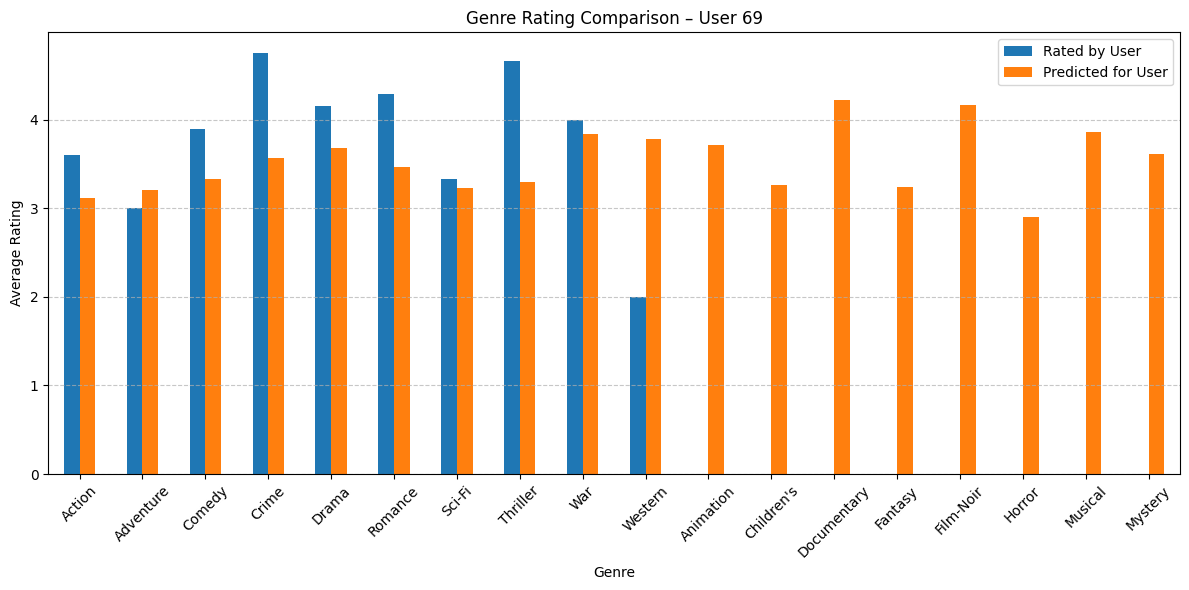

In [118]:
# --- Actual ratings from user's history ---
user_history_plot = ratings_merged[ratings_merged['UserID'] == selected_user][['Title', 'Genres_list', 'Rating']]
user_history_plot = user_history_plot.rename(columns={
    "Title": "Title",
    "Genres_list": "Genres",
    "Rating": "Actual Rating"
})
history_genres = user_history_plot.explode("Genres")  # one row per genre
avg_real = history_genres.groupby("Genres")["Actual Rating"].mean().rename("Avg Real Rating")

# --- Predicted ratings from ALL unseen movies ---
reco_genres_all = unseen_movies.rename(columns={
    "Genres_list": "Genres",
    "predicted_rating": "Predicted Rating (1–5)"
}).explode("Genres")
avg_pred = reco_genres_all.groupby("Genres")["Predicted Rating (1–5)"].mean().rename("Avg Predicted Rating")

# --- Combine into a single DataFrame ---
genre_comparison = pd.concat([avg_real, avg_pred], axis=1)

# --- Plot ---
genre_comparison.plot(kind="bar", figsize=(12, 6), rot=45)
plt.title(f"Genre Rating Comparison – User {selected_user}")
plt.ylabel("Average Rating")
plt.xlabel("Genre")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(["Rated by User", "Predicted for User"])
plt.tight_layout()
plt.show()